In [3]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

#### Проведение A/B тестирования

##### Дана таблица: 
##### ***id_client*** - уникальный идентификатор клиента
##### ***nflag_purchase*** - факт покупки (1 - приобретен рекламируемый товар, 0 - нет)

Задача
1. Исследуем зависимость пользования предложением от идентификатора клиента. 
2. Сделаем разбиение клиентов по группам (контроль и тест) в зависимости от остатка деления идентификатора на 10. Рассчитайте результаты АА-теста. Наблюдается ли разница?
3. Сделаем разбиение клиентов по группам (контроль и тест) в зависимости от четности идентификатора (остатка от деления идентификатора на 2). Рассчитайте результаты АА-теста. Наблюдается ли разница?
4. Сделаем  разбиение клиентов по группам (контроль и тест) с помощью функции sample из библиотеки pandas. По аналогии с расчетом из лекции сделайте 1000 разбиений с помощью sample и рассчитайте статистическую значимость разниц. В скольких процентах случаев наблюдается статистически значимая разница между контролем и тестом в АА-тесте?
5. Рассчитаем сколько наблюдений потребуется для проведения АБ Теста, при условии что MDE = 2 процентных пункта (предположите, что альфа и бета установлены на дефолтном уровне и что дисперсия выборки не изменится от воздействия В).

In [9]:
df= pd.read_csv('Домашнее задание Бизнес-4 (исходник).csv', sep = ';')
df.head(5)

,id_client,flag_conv
0,1345321,0
1,1345322,0
2,1345330,0
3,1345338,1
4,1345342,0


In [14]:
#### Разбиение на остаток от деления на 2 и на 10 
df['id_client_10'] = df['id_client'] % 10
df['id_client_2'] = df['id_client'] % 2
df['right_symbol_10'] = df['id_client_10'].astype(str).str[-1]
df['right_symbol_2'] = df['id_client_2'].astype(str).str[-1]
df.head(5)

,id_client,flag_conv,id_client_10,id_client_2,right_symbol_10,right_symbol_2
0,1345321,0,1,1,1,1
1,1345322,0,2,0,2,0
2,1345330,0,0,0,0,0
3,1345338,1,8,0,8,0
4,1345342,0,2,0,2,0


In [16]:
# Создание датафреймов для расчетов 
df['group_10'] = df['id_client'] % 10
df['group_10'] = df['group_10'].apply(lambda x: 'control' if x < 5 else 'test')
df['group_2'] = df['id_client'] % 2
df['group_2'] = df['group_2'].apply(lambda x: 'control' if x < 1 else 'test')
df.head(5)

,id_client,flag_conv,id_client_10,id_client_2,right_symbol_10,right_symbol_2,group_10,group_2
0,1345321,0,1,1,1,1,control,test
1,1345322,0,2,0,2,0,control,control
2,1345330,0,0,0,0,0,control,control
3,1345338,1,8,0,8,0,test,control
4,1345342,0,2,0,2,0,control,control


In [18]:
# создаем контрольную и тестовую группу 
df_control_2 = df[df['group_2'] == 'control']['flag_conv']
df_test_2 = df[df['group_2'] == 'test']['flag_conv']
df_control_10 = df[df['group_10'] == 'control']['flag_conv']
df_test_10 = df[df['group_10'] == 'test']['flag_conv']

In [20]:
#### Средние равны 
s, p = ttest_ind(df_control_2, df_test_2)
s, p

(2.303661902563631, 0.021306090686166332)

In [22]:
#### Средние не равны 
s, p = ttest_ind(df_control_10, df_test_10)
s, p

(3.761500955083385, 0.00017195329628373794)

#### Задача 1. График

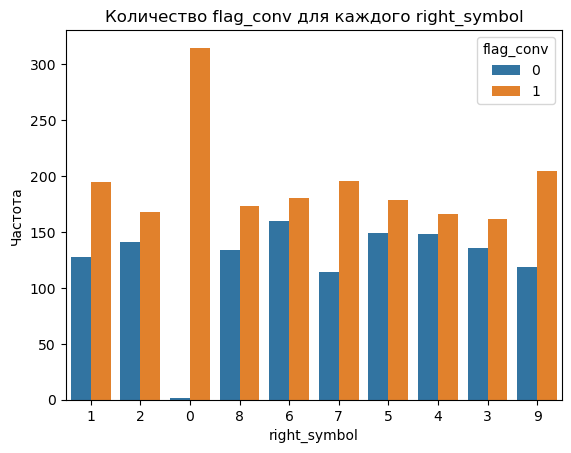

In [10]:
sns.countplot(data=df, x='right_symbol_10', hue='flag_conv')
plt.title('Количество flag_conv для каждого right_symbol')
plt.xlabel('right_symbol')
plt.ylabel('Частота')
plt.show()

#### Задача 4.  Функция АА теста

In [32]:

def AA_test(df, column, iterations=1000, alpha=0.05, frac=0.5):

    if column not in df.columns:
        raise ValueError(f"Столбец '{column}' отсутствует в датафрейме.")
    
    df_aa = pd.DataFrame(columns=['iter', 'stat_crit', 'p_value'])
    
    for i in range(1, iterations + 1):
        part_50 = df.sample(frac=frac, random_state=i)
        rest_part_50 = df.drop(part_50.index)
        
        s_a, p_a = ttest_ind(part_50[column], rest_part_50[column], equal_var=False)
        
        df_aa = pd.concat(
            [df_aa, pd.DataFrame({'iter': [i], 'stat_crit': [s_a], 'p_value': [p_a]})],
            ignore_index=True
        )
    
    significant_ratio = df_aa[df_aa['p_value'] <= alpha].shape[0] / df_aa.shape[0]
    
    print(f"Доля значимых результатов (p-value ≤ {alpha}): {significant_ratio:.2%}")
    
    return df_aa, significant_ratio


In [34]:
df_aa_results, significant_ratio = AA_test(df, column='flag_conv')

print(df_aa_results.head())
print('')

C:\Users\user\AppData\Local\Temp\ipykernel_21484\603370683.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aa = pd.concat(


Доля значимых результатов (p-value ≤ 0.05): 4.10%
  iter  stat_crit   p_value
0    1   1.079268  0.280550
1    2   0.131618  0.895295
2    3   0.641825  0.521033
3    4  -2.056164  0.039849
4    5  -0.232788  0.815941



#### Задача 5.  Расчет выборки

In [26]:
# Задание 5 
avg_conv = df['flag_conv'].mean()
d = avg_conv * (1 - avg_conv)
MDE = 0.02  
n = 16 * d/ MDE ** 2
print('Необходимое количество наблюдений для проведения А/Б-теста:')
print(int(n))

Необходимое количество наблюдений для проведения А/Б-теста:
9499
